### DirectoryFix

In [1]:
import os

# Get the current directory (which is likely wrong)
current_dir = os.getcwd()

# Navigate up until we find the project root ('EngineSentinel')
project_root = current_dir
while os.path.basename(project_root) != 'EngineSentinel':
    project_root = os.path.dirname(project_root)
    # Safety break to prevent infinite loop
    if project_root == os.path.dirname(project_root):
        print("Error: Could not find project root 'EngineSentinel'. Please check folder name.")
        break

# Change the current working directory to the project root
os.chdir(project_root)

print(f"Directory Fix Complete. New Current Working Directory: {os.getcwd()}")

Directory Fix Complete. New Current Working Directory: /Users/dhruv/Desktop/EngineSentinel


# Engine Sentinel - Model Training

In this notebook, we will use the processed data from our EDA to train and evaluate several machine learning models to predict the Remaining Useful Life (RUL) of turbofan engines.

### 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn tools for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
# Load the clean dataset from the artifacts folder
file_path = 'artifacts/processed_train_data.csv'
df = pd.read_csv(file_path)

print("Processed data loaded successfully!")
df.head()

Processed data loaded successfully!


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 2. Load the Processed Data

We will now load the `processed_train_data.csv` file that we created and saved in the previous notebook.

In [4]:
# Load the clean dataset from the artifacts folder
file_path = 'artifacts/processed_train_data.csv'
df = pd.read_csv(file_path)

print("Processed data loaded successfully!")
df.head()    

Processed data loaded successfully!


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 3. Prepare Data for Modeling: Features (X) and Target (y)

Before we can train a model, we need to clearly define our inputs and output.

* **Features (X):** These are the inputs the model will use to make a prediction. In our case, these are the operational settings and the 21 sensor readings. We will exclude columns like `unit_number` and `time_in_cycles` because they don't describe the engine's health at a specific moment.
* **Target (y):** This is the single value we want the model to predict. For us, this is the `RUL` column.

In [5]:
# The target variable is what we want to predict
y = df['RUL']

# The features are all the columns we will use for prediction
# We drop the target variable 'RUL' and the identifiers
X = df.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])

print("Features (X) and Target (y) have been separated.")
print(f"Shape of our features (X): {X.shape}")
print(f"Shape of our target (y): {y.shape}")

Features (X) and Target (y) have been separated.
Shape of our features (X): (20631, 24)
Shape of our target (y): (20631,)


### 4. Split Data into Training and Testing Sets

This is a critical step in machine learning. We need to evaluate how well our model performs on data it has **never seen before**.

To do this, we will split our dataset into two parts:
* **Training Set (80%):** The model will learn from this data.
* **Testing Set (20%):** We will hide this data from the model during training. Afterwards, we'll use it to test the model's predictions and see how accurate it is on new, unseen data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data has been split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data has been split into training and testing sets.
X_train shape: (16504, 24)
X_test shape: (4127, 24)
y_train shape: (16504,)
y_test shape: (4127,)


### 5. Train All Models

We will now train our three selected models: Random Forest, XGBoost, and LightGBM. We will create a dictionary to hold the untrained model instances and then loop through it, fitting each one to our training data (`X_train`, `y_train`). The trained models will be stored in a new dictionary for later use in the evaluation step.

In [ ]:
# Import all the models we want to test
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Create a dictionary of untrained model instances
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Create an empty dictionary to store the trained models
trained_models = {}

# Loop through each model and train it
print("--- Starting Model Training ---")
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Store the trained model
    trained_models[model_name] = model
    
    print(f"{model_name} training complete.")

print("\n--- All models have been trained successfully! ---")

--- Starting Model Training ---
Training Random Forest...
Random Forest training complete.
Training XGBoost...
XGBoost training complete.
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 17
[LightGBM] [Info] Start training from score 107.559683
LightGBM training complete.

--- All models have been trained successfully! ---


### 6. Evaluate Trained Models

Now that our models are trained, we can evaluate their performance on the unseen test data (`X_test`). We will loop through our dictionary of `trained_models`, use each one to make predictions, and then calculate our performance metrics. Finally, we will display the results in a table to compare them.

In [8]:
# Create an empty list to store the results
results = []

# Loop through each trained model, evaluate it, and store the results
print("--- Starting Model Evaluation ---")
for model_name, model in trained_models.items():
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Evaluating {model_name} - MAE: {mae:.2f}, R² Score: {r2:.2f}")
    
    # Store the results
    results.append({
        'Model': model_name,
        'Mean Absolute Error': mae,
        'R² Score': r2
    })

print("\n--- Model Comparison ---")
# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results, sorted by the best R² Score
display(results_df.sort_values(by='R² Score', ascending=False))

--- Starting Model Evaluation ---
Evaluating Random Forest - MAE: 29.69, R² Score: 0.62
Evaluating XGBoost - MAE: 31.03, R² Score: 0.59
Evaluating LightGBM - MAE: 29.88, R² Score: 0.62

--- Model Comparison ---


,Model,Mean Absolute Error,R² Score
0,Random Forest,29.688842,0.622651
2,LightGBM,29.883830,0.621548
1,XGBoost,31.029350,0.587489


### 9. Visualize Model Predictions

Numbers are great, but a picture is often more insightful. Let's create a scatter plot to compare the `y_test` (the true RUL values) against the `y_pred` (the predictions from our best model).

In a perfect model, all the dots would fall on a straight diagonal line. The more scattered the dots are, the less accurate the predictions. We will use the LightGBM model for this visualization since it performed the best and is very fast.

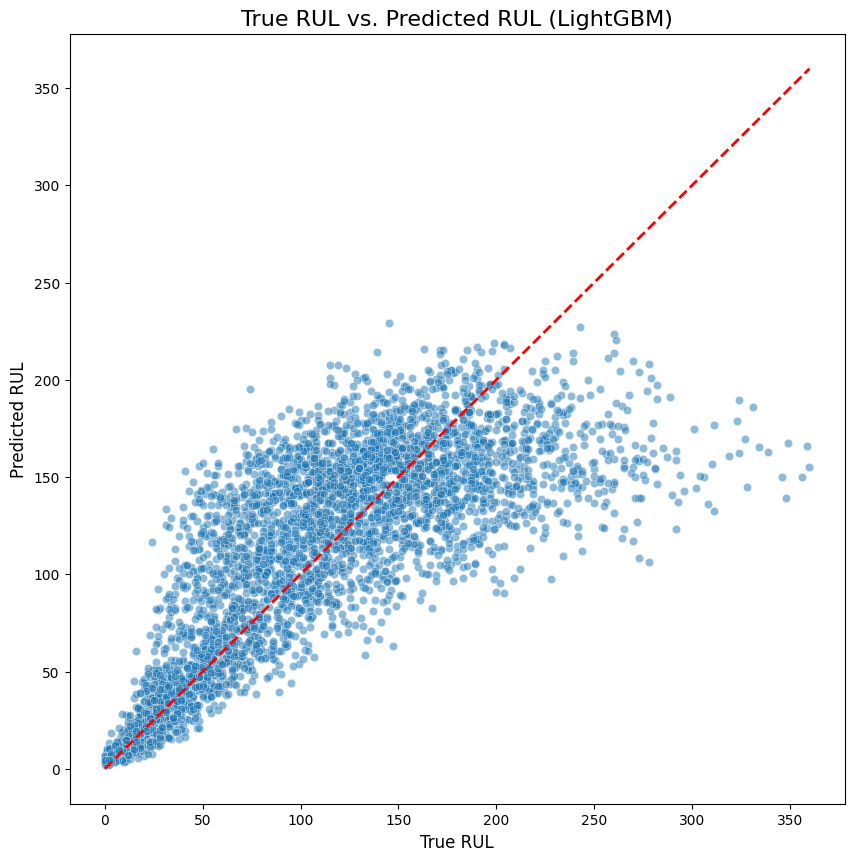

In [9]:
# Select our best model (LightGBM)
best_model = trained_models['LightGBM']

# Get its predictions on the test set
y_pred = best_model.predict(X_test)

# Create the scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Add a line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)

plt.title('True RUL vs. Predicted RUL (LightGBM)', fontsize=16)
plt.xlabel('True RUL', fontsize=12)
plt.ylabel('Predicted RUL', fontsize=12)
plt.show()

---
### Bonus Section: Framing as a Classification Problem

To demonstrate a different approach, we can reframe our problem from regression to classification. Instead of predicting the *exact* RUL, we will predict a simpler, binary outcome: **"Is this engine likely to fail within the next 30 cycles?"**

This allows us to use classification metrics like Accuracy and a Confusion Matrix. We will create a new target variable where:
- `1` = The engine will fail within 30 cycles (`RUL <= 30`).
- `0` = The engine is healthy (`RUL > 30`).

In [11]:
# Create a new binary target variable for classification using the original dataframe 'df'
df['will_fail_soon'] = np.where(df['RUL'] <= 30, 1, 0)

# Display the value counts to see how many data points are in each class
print("Class Distribution:")
print(df['will_fail_soon'].value_counts())

Class Distribution:
will_fail_soon
0    17531
1     3100
Name: count, dtype: int64


In [12]:
# Import the necessary tools for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Define our new features (X_c) and target (y_c) for classification
# Note: We are dropping the original RUL and the new target from our features
y_c = df['will_fail_soon']
X_c = df.drop(columns=['RUL', 'unit_number', 'time_in_cycles', 'will_fail_soon'])

# Split the data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Create and train a RandomForestClassifier model
clf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Training classifier model...")
clf_model.fit(X_train_c, y_train_c)
print("Training complete.")

Training classifier model...
Training complete.


Model Accuracy: 96.15%

Confusion Matrix:


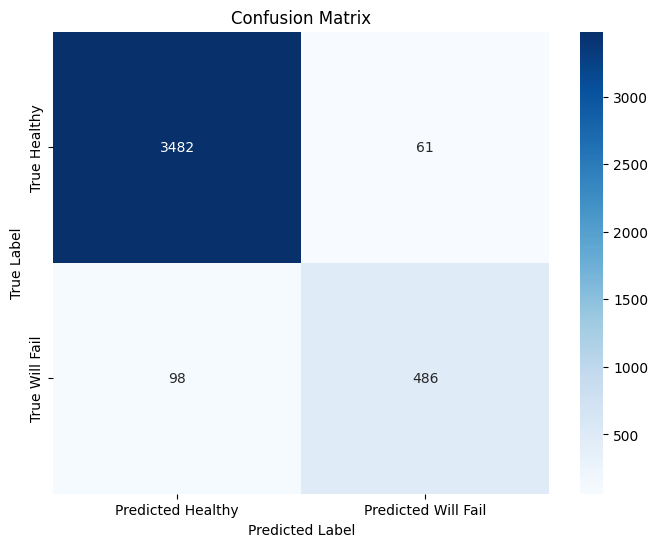

In [13]:
# Make predictions on the test set
y_pred_c = clf_model.predict(X_test_c)

# --- Calculate and Display Metrics ---

# 1. Accuracy Score
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Model Accuracy: {accuracy:.2%}")

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_c, y_pred_c)

# Visualize the confusion matrix with seaborn for better interpretation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Healthy', 'Predicted Will Fail'], 
            yticklabels=['True Healthy', 'True Will Fail'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()